In [88]:
from __future__ import division
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", 200)

%matplotlib inline

In [151]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.manifold import MDS


from Tools import frecuencia, metricas

import pickle

In [52]:
df=pd.read_csv("Starbucks_Cluster_600_rempl.csv", index_col="Unnamed: 0")
df.Bebida.replace(["Cold ","0"], ["Cold", np.nan]
                  , inplace=True)
df.Bebida.replace(["Jugo","CJQ", "Te"], np.nan, inplace=True)
df["Local/Llegar"].replace("Local ","Local", inplace=True)
df.dropna(inplace=True)

In [54]:
frecuencia(df, "Bebida")

,Bebida,Conteo,Frecuencia
0,Hot,387,0.728814
1,Cold,80,0.150659
2,Frappe,64,0.120527


In [177]:
lbl=LabelEncoder()
lbl.fit(df.Bebida)
df.Bebida=lbl.transform(df.Bebida)

In [57]:
df.Hora=pd.to_timedelta(df.Hora.map(lambda x: x+":00")).dt.seconds/60**2


In [59]:
df.head()

,Dinero gastado,Total personas,Total Hombres,Total Mujeres,Hora,Edad,Local/Llegar,Bebida,Comida,Dia,cl
0,25,1,0,1,8.100000,20-30,Local,2,0,martes,Trabajador
1,29,1,0,1,8.116667,40-50,Local,2,Rollo,martes,Trabajador
2,48,1,0,1,8.150000,20-30,Llevar,2,0,martes,Trabajador
3,0,1,1,0,8.166667,40-50,Local,1,0,martes,Trabajador
6,25,1,1,0,8.483333,40-50,Llevar,2,0,martes,Trabajador


In [61]:
df=pd.concat([df,pd.get_dummies(df["Local/Llegar"]), pd.get_dummies(df.cl),
              pd.get_dummies(df.Dia)], axis=1).copy()
#df.Dia=df.Dia.map({"martes":2, "miercoles":3, "jueves":4,"viernes":5, "sabado":6, "domingo":0})

In [62]:
var=["Total personas", "Total Hombres", "Total Mujeres", "Hora", 
     "domingo", "jueves" , "martes" , "miercoles", "sabado","viernes",
     "Amigos", "Estudiante" ,"Parejas","Trabajador"]

In [81]:
X=df[var].copy()
y=df["Bebida"].reset_index(drop=True)

In [78]:
std=StandardScaler()
std.fit(X)
Xs=pd.DataFrame(std.transform(X), columns=X.columns)

In [157]:
n=10
pca=PCA(n_components=n)
pca.fit(Xs)

Xp=pd.DataFrame(pca.transform(Xs), columns=["p%s" %s for s in range(1,n+1)])
pca.explained_variance_ratio_.sum()

0.9837905013426772

In [150]:
scx=MinMaxScaler()
scy=MinMaxScaler()
scx.fit(X)
scy.fit(y.reshape(-1,1))
Xm=pd.DataFrame(scx.transform(X), columns=X.columns)
ym=pd.DataFrame(scy.transform(y.reshape(-1,1)))

C:\Users\Comdisde\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.
C:\Users\Comdisde\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [67]:
Xt, Xv, yt, yv= train_test_split(Xp,y, test_size=.3)

# ML

In [44]:
model=XGBClassifier()
model.fit(Xt, yt)
print model.score(X=Xt,y=yt)
print model.score(X=Xv,y=yv)

0.894878706199461
0.78125


C:\Users\Comdisde\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Comdisde\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [170]:
param_grid_XGB=dict(max_depth=range(15,30,3), n_estimators=range(1000,2000,100), 
                learning_rate=np.arange(.001,.011,.001), booster=["gbtree", "gblinear", "dart"],
                    base_score=np.arange(.1,1.1,.1)
                   )

param_grid_RF=dict(n_estimators=range(1000,10000,100), criterion=["gini",  "entropy"],
                  bootstrap=[True],  min_samples_split=range(200,500,100), 
                   min_samples_leaf=range(1000,5000,500),max_features=["auto", "sqrt", "log2"]
                   )

param_grid_RED=dict(hidden_layer_sizes=[(x,y,z) for x in range(100,1000,100) 
                                        for y in range(100,1000,100) for z in range(100,1000,100)],
                   activation=['identity', 'logistic', 'tanh', 'relu'], 
                   solver=["lbfgs", "sgd","adam"], learning_rate_init=np.arange(.0001, .001,.001),            
                   learning_rate=['constant', 'invscaling', 'adaptive'], max_iter=[2000])

param_grid_AD=dict(n_estimators=range(1000,10000,100),)


param_grid_svc=dict(C=np.arange(.5,2,.1),kernel=["rbf", "linear", "poly", "sigmoid"], degree=range(1,10),
                   coef0=np.arange(.001,.011,.001), decision_function_shape=['ovo', 'ovr',None], 
                    probability=[True])


grid= GridSearchCV(model,scoring="accuracy", verbose=True
                     , param_grid=param_grid_svc, cv=8, n_jobs=-1)




grid.fit(Xt, yt)

Fitting 8 folds for each of 16200 candidates, totalling 129600 fits


[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 2872 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 6872 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 12472 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 19672 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 28472 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 38872 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 50872 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 64472 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 79672 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 96472 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 114872 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 129600 out of 129600 | elapsed: 17.7min finished


GridSearchCV(cv=8, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'C': array([ 0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,
        1.6,  1.7,  1.8,  1.9]), 'degree': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'probability': [True], 'coef0': array([ 0.001,  0.002,  0.003,  0.004,  0.005,  0.006,  0.007,  0.008,
        0.009,  0.01 ]), 'decision_function_shape': ['ovo', 'ovr', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=True)

In [175]:
modelhy=grid.best_estimator_
print accuracy_score(modelhy.predict(Xt), yt)
print accuracy_score(modelhy.predict(Xv), yv)
print f1_score(average='weighted', y_pred=modelhy.predict(Xt), y_true=yt)
print f1_score(average='weighted', y_pred=modelhy.predict(Xv), y_true=yv)

0.787061994609
0.725
0.737891133355
0.66292759324


In [97]:
a=pickle.load(open("72% bebidas MLP get dummies", "rb"))

In [98]:
b=pickle.load(open("72% bebidas Log get dummies", "rb"))

In [99]:
c=pickle.load(open("73% bebidas RF get dummies", "rb"))

In [102]:
d=pickle.load(open("73% bebidas vc get dummies", "rb"))

In [118]:
e=pickle.load(open("72% bebidas EXT get dummies", "rb"))

In [185]:
f=pickle.load(open("76% bebidas svc get dummies", "rb"))

In [68]:
g=pickle.load(open("75% bebidas vc get dummies", "rb"))

In [187]:
vc = VotingClassifier(estimators=[('RED', a), ("Log", b), ("RF", c), 
                                  ("vc",d), ("svc", f), ("XGB",modelhy), ("vc2",g)],
                 voting='soft')

vc.fit(Xt,yt)


print accuracy_score(vc.predict(Xt), yt)
print accuracy_score(vc.predict(Xv), yv)
print f1_score(average='weighted', y_pred=vc.predict(Xt), y_true=yt)
print f1_score(average='weighted', y_pred=vc.predict(Xv), y_true=yv)

0.757412398922
0.725
0.678351142467
0.631266229329


In [69]:
print accuracy_score(g.predict(Xt), yt)
print accuracy_score(g.predict(Xv), yv)
print f1_score(average='weighted', y_pred=g.predict(Xt), y_true=yt)
print f1_score(average='weighted', y_pred=g.predict(Xv), y_true=yv)

C:\Users\Comdisde\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6954177897574124


C:\Users\Comdisde\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.775


C:\Users\Comdisde\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.5968236239257007
0.6989316239316239


C:\Users\Comdisde\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [193]:
pickle.dump(pca,open("PCA get dummies", "wb"))

In [165]:
mds=MDS(n_components=2)
Xmm=pd.DataFrame(mds.fit_transform(Xm), columns=["d1","d2"])


In [180]:
Xmm["Predict"]=lbl.inverse_transform(g.predict(Xp))

C:\Users\Comdisde\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Comdisde\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


C:\Users\Comdisde\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


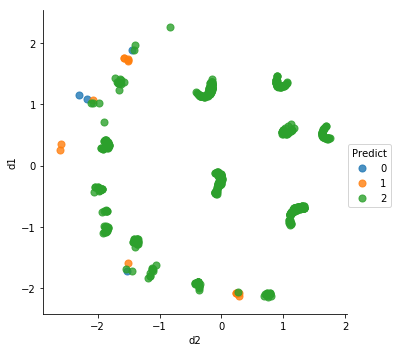

In [182]:

sns.lmplot(fit_reg=False,data=pd.concat([Xmm, pd.Series(lbl.inverse_transform(y))]
                                        , axis=1), x="d2",y="d1",hue="Predict", size=5,
            scatter_kws={'s':50})

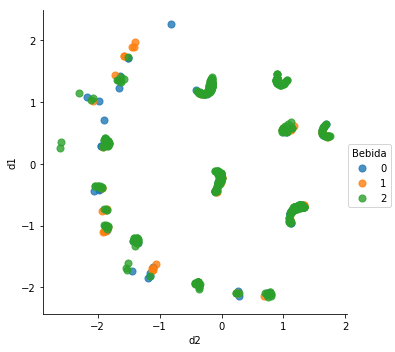

In [183]:

sns.lmplot(fit_reg=False,data=pd.concat([Xmm, y], axis=1), x="d2",y="d1",hue="Bebida", size=5,
            scatter_kws={'s':50})